# Calling Azure ML Designer model

<img src="https://docs.microsoft.com/en-us/azure/machine-learning/media/overview-what-is-azure-ml/designer-drag-and-drop.gif">

<img src="https://docs.microsoft.com/en-us/azure/machine-learning/media/algorithm-cheat-sheet/machine-learning-algorithm-cheat-sheet.svg">

## 1. Information session

In [23]:
import sys
print("Version Python :",sys.version)

Version Python : 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [24]:
import datetime
date = datetime.datetime.now()
print("Date Heure :", str(date))

Date Heure : 2020-08-28 12:37:40.050820


## 2. Importation des librairies

In [25]:
import urllib.request
import json
import os
import ssl

In [26]:
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

In [27]:
ws = Workspace.from_config()

experiment_name = 'AutoMLTitanicSDK'

In [28]:
def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

## 3. Premier exemple

In [29]:
# URL de l'image à analyser
image_url = "https://github.com/retkowsky/images/blob/master/titanic1.jpg?raw=true"

<img src="https://github.com/retkowsky/images/blob/master/titanic1.jpg?raw=true" width="600">

### 3.1 Exemple Face Detection Azure

In [30]:
import requests
import matplotlib.pyplot as plt
import json
from PIL import Image
from io import BytesIO

In [31]:
# Ma clef
subscription_key = "7ad08230f7d64dabb90da6e91126a6df"
assert subscription_key

In [32]:
# Endpoint API
vision_base_url = "https://westeurope.api.cognitive.microsoft.com/vision/v2.0/"
analyze_url = vision_base_url + "analyze"

In [33]:
headers = {'Ocp-Apim-Subscription-Key': subscription_key }
params  = {'visualFeatures': 'Categories,Description,Color'}
data    = {'url': image_url}
response = requests.post(analyze_url, headers=headers, params=params, json=data)
response.raise_for_status()

analysis = response.json()

print(json.dumps(response.json()))
image_caption = analysis["description"]["captions"][0]["text"].capitalize()

{"categories": [{"name": "people_portrait", "score": 0.6875, "detail": {"celebrities": [{"name": "Leonardo DiCaprio", "confidence": 0.7701433300971985, "faceRectangle": {"left": 580, "top": 196, "width": 418, "height": 418}}]}}], "color": {"dominantColorForeground": "Black", "dominantColorBackground": "Black", "dominantColors": ["Black", "Brown"], "accentColor": "545644", "isBwImg": false, "isBWImg": false}, "description": {"tags": ["person", "man", "necktie", "suit", "indoor", "clothing", "wearing", "photo", "camera", "posing", "looking", "smiling", "front", "shirt", "sitting", "dressed", "young", "standing", "glasses", "people", "holding", "wedding"], "captions": [{"text": "Leonardo DiCaprio wearing a suit and tie smiling at the camera", "confidence": 0.9927912432352272}]}, "requestId": "ce83f931-80c6-4934-8d3d-c1e684427fae", "metadata": {"height": 900, "width": 1600, "format": "Jpeg"}}


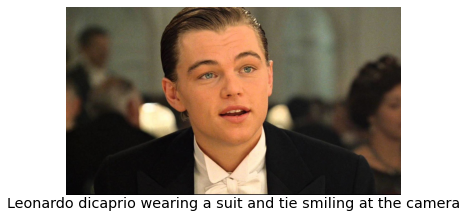

In [34]:
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)
plt.axis("off")
_ = plt.title(image_caption, size="x-large", y=-0.1)
plt.show()

### 3.2 Estimation de l'âge

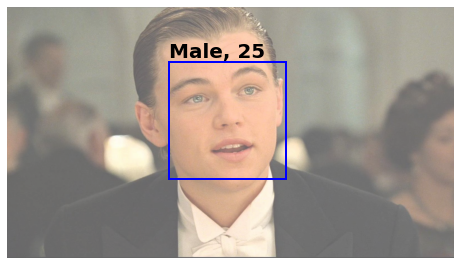

In [35]:
subscription_key = "2d35458d0b5a4a3db5ad229352b8d5d8"

assert subscription_key

face_api_url = 'https://westeurope.api.cognitive.microsoft.com/face/v1.0/detect'
image_url = 'https://github.com/retkowsky/images/blob/master/titanic1.jpg?raw=true'

import requests
from IPython.display import HTML

headers = { 'Ocp-Apim-Subscription-Key': subscription_key }
    
params = {
    'returnFaceId': 'true',
    'returnFaceLandmarks': 'false',
    'returnFaceAttributes': 'age,gender,headPose,smile,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise',
}

response = requests.post(face_api_url, params=params, headers=headers, json={"url": image_url})
faces = response.json()
HTML("<font size=5>Detected <font color='blue'>%d</font> faces in the image</font>"%len(faces))
%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib import patches
from io import BytesIO

response = requests.get(image_url)
image = Image.open(BytesIO(response.content))

plt.figure(figsize=(8,8))
ax = plt.imshow(image, alpha=0.6)
for face in faces:
    fr = face["faceRectangle"]
    fa = face["faceAttributes"]
    origin = (fr["left"], fr["top"])
    p = patches.Rectangle(origin, fr["width"], fr["height"], fill=False, linewidth=2, color='b')
    ax.axes.add_patch(p)
    plt.text(origin[0], origin[1], "%s, %d"%(fa["gender"].capitalize(), fa["age"]), fontsize=20, weight="bold", va="bottom")
_ = plt.axis("off")

### 3.3 Génération des données en entrée du modèle de ML

In [39]:
leonardo = {
    "Inputs": {
          "WebServiceInput0":
          [
              {
                    'PassengerId': "892",
                    'Pclass': "3",
                    'Name': "Leonardo",
                    'Sex': "male",
                    'Age': "25",
                    'SibSp': "0",
                    'Parch': "0",
                    'Ticket': "330911",
                    'Fare': "7.8292",
                    'Cabin': "1",
                    'Embarked': "Q",
              },
          ],
    },
    "GlobalParameters":  {
    }
}


In [40]:
leonardo

{'Inputs': {'WebServiceInput0': [{'PassengerId': '892',
    'Pclass': '3',
    'Name': 'Leonardo',
    'Sex': 'male',
    'Age': '25',
    'SibSp': '0',
    'Parch': '0',
    'Ticket': '330911',
    'Fare': '7.8292',
    'Cabin': '1',
    'Embarked': 'Q'}]},
 'GlobalParameters': {}}

### 3.4 Appel au modèle de ML déployé par Azure ML

In [42]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.


body = str.encode(json.dumps(leonardo))

url = 'http://52.148.242.117:80/api/v1/service/titanic-real-time/score'
api_key = '8y8wrASdQDUhjJOvkhzhYHmx5H4PAiNB' # Replace this with the API key for the web service
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(json.loads(error.read().decode("utf8", 'ignore')))



b'{"Results": {"WebServiceOutput0": [{"ID": 892.0, "Survival": 0.0, "Probability": 0.03571428571428571}]}}'


> ### Résultat : <span style="color: red;">*Pas de survie* </span>

## 4. Second exemple

<img src="https://github.com/retkowsky/images/blob/master/titanic02.jpg?raw=true" width="600">

In [43]:
kate = {
    "Inputs": {
          "WebServiceInput0":
          [
              {
                    'PassengerId': "892",
                    'Pclass': "1",
                    'Name': "KAte",
                    'Sex': "female",
                    'Age': "22",
                    'SibSp': "0",
                    'Parch': "0",
                    'Ticket': "330911",
                    'Fare': "7.8292",
                    'Cabin': "1",
                    'Embarked': "Q",
              },
          ],
    },
    "GlobalParameters":  {
    }
}


In [44]:
kate

{'Inputs': {'WebServiceInput0': [{'PassengerId': '892',
    'Pclass': '1',
    'Name': 'KAte',
    'Sex': 'female',
    'Age': '22',
    'SibSp': '0',
    'Parch': '0',
    'Ticket': '330911',
    'Fare': '7.8292',
    'Cabin': '1',
    'Embarked': 'Q'}]},
 'GlobalParameters': {}}

In [45]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.


body = str.encode(json.dumps(kate))

url = 'http://52.148.242.117:80/api/v1/service/titanic-real-time/score'
api_key = '8y8wrASdQDUhjJOvkhzhYHmx5H4PAiNB' # Replace this with the API key for the web service
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(json.loads(error.read().decode("utf8", 'ignore')))



b'{"Results": {"WebServiceOutput0": [{"ID": 892.0, "Survival": 1.0, "Probability": 0.875}]}}'


> ### Résultat : <span style="color: green;">*Survie* </span>